In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import time
import json
import scvi
import numpy as np

In [2]:
sc.set_figure_params(figsize=(4, 4))

In [3]:
deep_inject = False
n_epochs_surgery = 300
test_nr = 2
batch_key = "study"
cell_type_key = "cell_type"

In [4]:
n_epochs_vae = 500
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [5]:
# Save right dir path
if deep_inject:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_results/figure_3/scvi/brain/test_{test_nr}_deep_cond/')
else:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_results/figure_3/scvi/brain/test_{test_nr}_first_cond/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Adata Handling

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/mouse_brain_subsampled_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 332129 × 4000
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'size_factors'

In [7]:
if test_nr == 1:
    reference = ['Rosenberg']
    query = ['Saunders', 'Zeisel', 'Tabula_muris']
elif test_nr == 2:
    reference = ['Rosenberg', 'Saunders']
    query = ['Zeisel', 'Tabula_muris']
elif test_nr == 3:
    reference = ['Rosenberg', 'Saunders', 'Zeisel']
    query = ['Tabula_muris']

In [8]:
ref_ind = np.array([s in reference for s in adata.obs.study])
query_ind = np.array([s in query for s in adata.obs.study])
adata_ref = adata[ref_ind].copy()
adata_query = adata[query_ind].copy()

/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [9]:
adata_ref

AnnData object with n_obs × n_vars = 133435 × 4000
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'size_factors'

In [10]:
adata_query

AnnData object with n_obs × n_vars = 198694 × 4000
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'size_factors'

In [11]:
scvi.data.setup_anndata(adata_ref, batch_key=batch_key)

INFO      Using batches from adata.obs["study"]                                              
INFO      No label_key inputted, assuming all cells have same label                          
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 133435 cells, 4000 vars, 1       
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# Create SCVI model and train

In [12]:
vae = scvi.model.SCVI(
    adata_ref,
    n_layers=2,
    use_cuda=True,
    encode_covariates=True,
    deeply_inject_covariates=deep_inject,
    use_layer_norm="both",
    use_batch_norm="none",
    use_observed_lib_size=True
)

In [13]:
ref_time = time.time()
vae.train(n_epochs=n_epochs_vae, frequency=1, early_stopping_kwargs=early_stopping_kwargs)
ref_time = time.time() - ref_time

INFO      Training for 500 epochs                                                            
INFO      KL warmup for 400 epochs                                                           
Training...:  61%|██████    | 303/500 [49:15<31:14,  9.51s/it]INFO                                                                                         
          Stopping early: no improvement of more than 0 nats in 10 epochs                    
INFO      If the early stopping criterion is too strong, please instantiate it with different
          parameters in the train method.                                                    
Training...:  61%|██████    | 303/500 [49:25<32:07,  9.79s/it]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  1951 s. / 500 epochs                                               


# Reference Evaluation

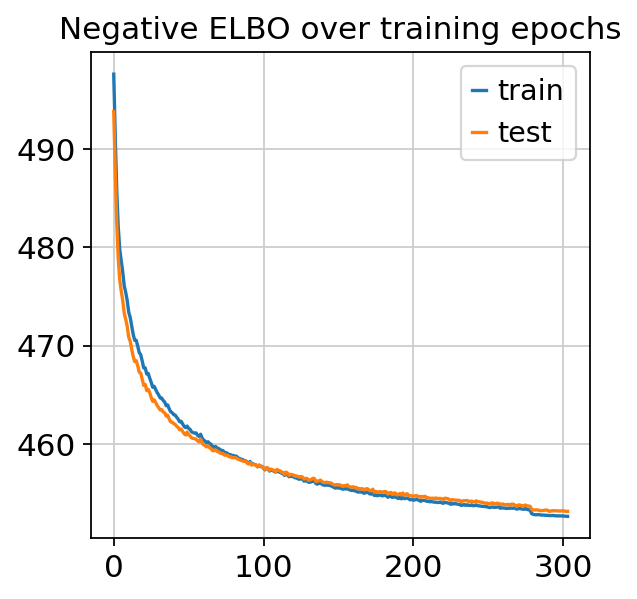

In [14]:
plt.plot(vae.trainer.history["elbo_train_set"][2:], label="train")
plt.plot(vae.trainer.history["elbo_test_set"][2:], label="test")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [15]:
adata_ref.obsm["X_scVI"] = vae.get_latent_representation()

<Figure size 320x320 with 0 Axes>

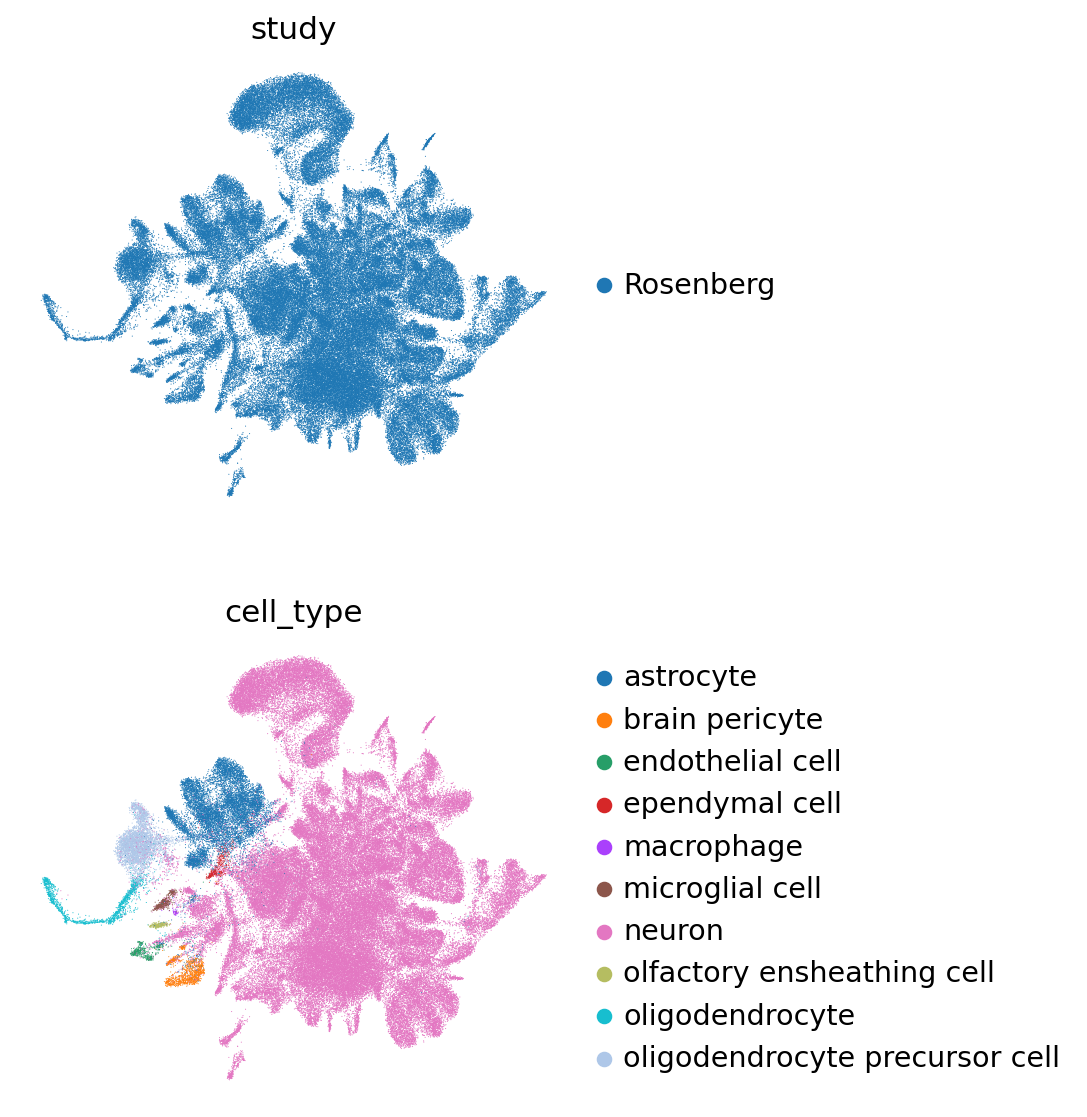

In [16]:
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)
plt.figure()
sc.pl.umap(
    adata_ref,
    color=[batch_key, cell_type_key],
    frameon=False,
    ncols=1,
)

In [17]:
adata_ref.write_h5ad(filename=f'{dir_path}reference_data.h5ad')
torch.save(vae.model.state_dict(), f'{dir_path}reference_model_state_dict')
ref_path = f'{dir_path}ref_model/'
if not os.path.exists(ref_path):
    os.makedirs(ref_path)
vae.save(ref_path, overwrite=True)

# Run surgery on query data

In [18]:
model = scvi.model.SCVI.load_query_data(
    adata_query,
    ref_path,
    use_cuda=True,
    freeze_batchnorm_encoder=True,
    freeze_batchnorm_decoder=True,
    freeze_expression=True
)

INFO      .obs[_scvi_labels] not found in target, assuming every cell is same category       
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']    
INFO      Successfully registered anndata object containing 198694 cells, 4000 vars, 4       
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 


/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [19]:
query_time = time.time()
model.train(n_epochs=n_epochs_surgery, frequency=1, early_stopping_kwargs=early_stopping_kwargs, weight_decay=0)
query_time = time.time() - query_time

INFO      Training for 300 epochs                                                            
INFO      KL warmup phase exceeds overall training phaseIf your applications rely on the     
          posterior quality, consider training for more epochs or reducing the kl warmup.    
INFO      KL warmup for 400 epochs                                                           
Training...: 100%|██████████| 300/300 [1:13:21<00:00, 14.67s/it]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  2704 s. / 300 epochs                                               


# Evaluation Surgery on Query1

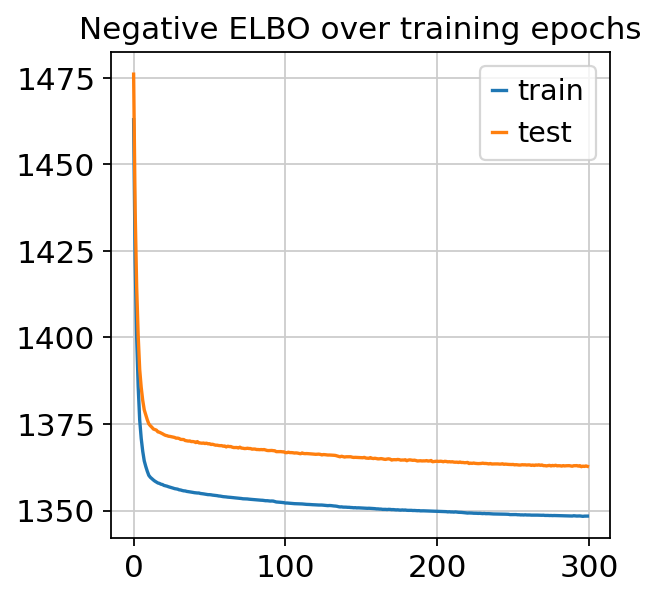

In [20]:
plt.figure()
plt.plot(model.trainer.history["elbo_train_set"][2:], label="train")
plt.plot(model.trainer.history["elbo_test_set"][2:], label="test")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [21]:
adata_query.obsm["X_scVI"] = model.get_latent_representation()

<Figure size 320x320 with 0 Axes>

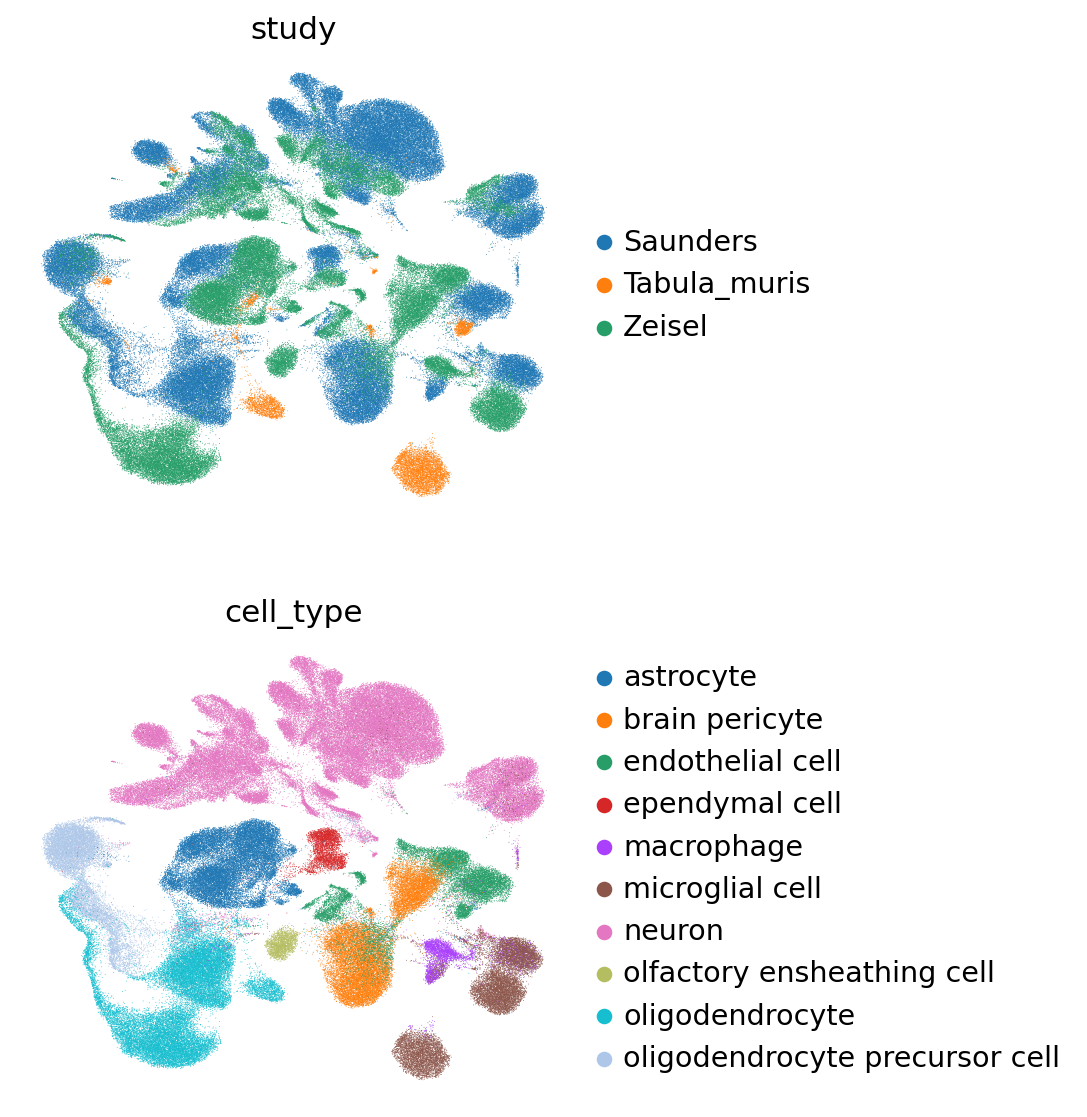

In [22]:
sc.pp.neighbors(adata_query, use_rep="X_scVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)
plt.figure()
sc.pl.umap(
    adata_query,
    color=[batch_key, cell_type_key],
    frameon=False,
    ncols=1,
)

In [23]:
adata_query.write_h5ad(filename=f'{dir_path}query_data.h5ad')

# Evaluation Query on reference

In [24]:
adata_full = adata_ref.concatenate(adata_query)
adata_full.uns["_scvi"] = adata_query.uns["_scvi"]
print(adata_full.obs[batch_key].unique())
print(adata_full.obs["_scvi_batch"].unique())
adata_full.obsm["X_scVI"] = model.get_latent_representation(adata=adata_full)

['Rosenberg' 'Saunders' 'Tabula_muris' 'Zeisel']
[0 1 2 3]


/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Age' as categorical
... storing 'Subclass' as categorical
... storing 'Taxonomy_group' as categorical
... storing 'Tissue' as categorical
... storing 'age' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'class' as categorical
... storing 'cluster' as categorical
... storing 'cluster_id' as categorical
... storing 'louvain' as categorical
... storing 'reason' as categorical
... storing 'refined_class' as categorical
... storing 'region' as categorical
... storing 'region_subcluster' as categorical
... storing 'sample_type' as categorical
... storing 'study' as categorical
... storing 'subcluster' as categorical


<Figure size 320x320 with 0 Axes>

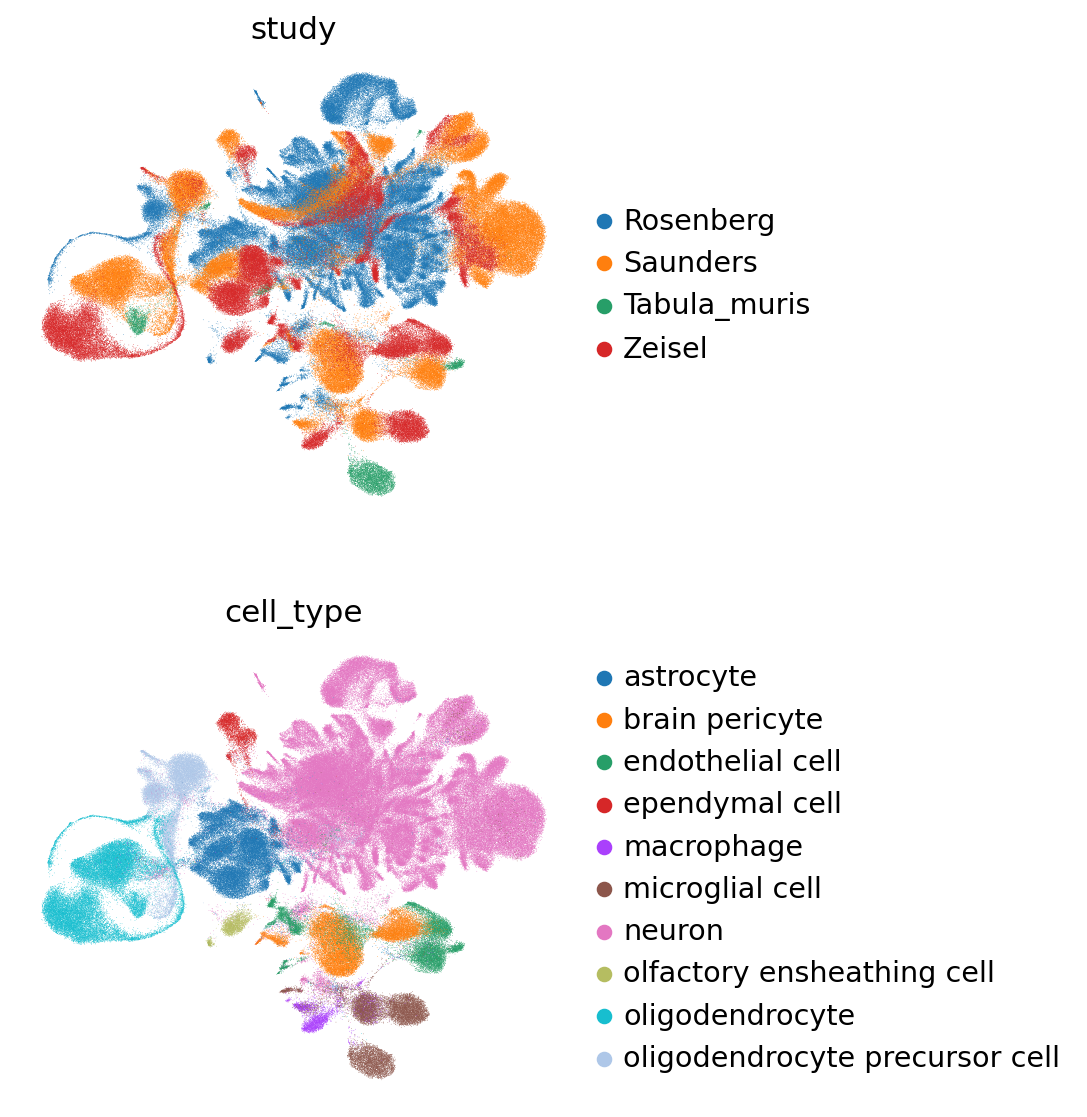

In [25]:
sc.pp.neighbors(adata_full, use_rep="X_scVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)
plt.figure()
sc.pl.umap(
    adata_full,
    color=[batch_key, cell_type_key],
    frameon=False,
    ncols=1,
)

In [26]:
adata_full.write_h5ad(filename=f'{dir_path}full_data.h5ad')
torch.save(model.model.state_dict(), f'{dir_path}surgery_model_state_dict')
surgery_path = f'{dir_path}surg_model/'
if not os.path.exists(surgery_path):
    os.makedirs(surgery_path)
model.save(surgery_path, overwrite=True)

In [27]:
times = dict()
times["ref_time"] = ref_time
times["query_time"] = query_time
times["full_time"] = ref_time + query_time
with open(f'{dir_path}results_times.txt', 'w') as filehandle:
    json.dump(times, filehandle)